In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time

In [9]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

def BSMforwardPrice(St, K, T, t, r, q):
    return St*np.exp(-q*(T-t)) - K*np.exp(-r*(T-t))

def BSMzeroCouponBondPrice(T, t, r):
    return np.exp(-r*(T-t))

The quanto call option analytical formula is
$$
e^{-r T}\left(\tilde{M}_0 N\left(\frac{\log \left(\frac{\tilde{M}_0}{K}\right)+\frac{1}{2} \sigma_M^2 T}{\sigma_M \sqrt{T}}\right)-K N\left(\frac{\log \left(\frac{\tilde{M}_0}{K}\right)-\frac{1}{2} \sigma_M^2 T}{\sigma_M \sqrt{T}}\right)\right) .
$$

and

$$
\tilde{M}_0=M_0 e^{\left(d-\rho \sigma_F \sigma_M\right) T}
$$

where

$M0$ is the initial price of the stock in dollars

$d$ is the drift of the dollar stock which can be taken as a dividend

$\rho$ is the correlation of the random movements of the stock and exchange rate

$\sigma_M$ is the standard deviation of the dollar stock

$\sigma_F$ is the standard deviation of the exchange rate

$T$ is maturity

and the rest of the terms have the familliar definitions

In [10]:
def QunatoCallOption(Mt, K, T, t, r, d, sigmaF, sigmaM, rho):
    tau = T-t
    Mt_tilde = Mt*np.exp((d - rho*sigmaF*sigmaM)*tau)
    _d1 = sp.special.ndtr(d1(Mt_tilde, K, T, t, 0, 0, sigmaM))
    _d2 = sp.special.ndtr(d2(Mt_tilde, K, T, t, 0, 0, sigmaM))
    return np.exp(-r*tau)*(Mt_tilde*_d1 - K*_d2)

The Margrabe option call has the following formula

$$
D\left(S_1, S_2, t\right)=S_2 N\left(d_2\right)-S_1 N\left(d_1\right)
$$

where

$$d_j=\frac{\log \left(S_2 / S_1\right)+(-1)^{j-1} \frac{1}{2} \bar{\sigma}^2\left(T-t\right)}{\bar{\sigma} \sqrt{T-t}} .
$$

and

$$
\bar{\sigma}=\sqrt{\sigma_1^2-2 \rho \sigma_1 \sigma_2+\sigma_2^2}.
$$

$S_1$ is the main underlying

$\sigma_1$ is the standard deviation of sotkc 1

$\sigma_2$ is the standard deviation of stock 2

In [11]:
def OneDGBMPathGenerator(N_paths,S0,T,r,q,sigma, W):
    """
    N_paths : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    W : random number array
    """
    return S0*np.exp((r-q-sigma**2/2)*np.repeat(np.array([T]),N_paths) + sigma*np.sqrt(T)*W)

In [12]:
def GBMPathGenerator(n_steps,n_paths,S0,T,r,q,sigma, Z):
    """
    n_steps : dimensionality / number of increments
    n_paths : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    Z : the standard Wiener process
    """
    times = np.linspace(0., T, n_steps)
    timesArray = np.repeat(times.reshape(n_steps,1), n_paths, axis = 1)
    S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*Z)
    return S

In [13]:
def WienerProcessGenerator(n_steps, n_paths, dt):
    # Wt2 - Wt1 ~ Normal with mean 0 and variance t2-t1
    dW = np.zeros((n_steps, n_paths))
    dW[1:, :] = np.sqrt(dt) * np.random.normal(size=(n_steps-1, n_paths))
    # Simulation of Arithmetic brownian motion
    W = np.cumsum(dW, axis=0)
    return W

In [14]:
def MonteCarloCall(S, K, T, t, dt):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """
    if(S.ndim == 1):
        return np.mean(np.maximum(S - K,0))*np.exp(-r*(T-t))

    if(S.ndim == 2):
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(np.maximum(S[t_idx,:] - K,0))*np.exp(-r*(T-t))


$B_t$ is the sterling money market account growing with r rate

$D_t$ is the dollar money market account which grows with d rate

$F_t$ is the value of $1$ dollar in pounds

$M_t$ is the dollar value of an underlying / asset

$$
d B_t =r B_t d t
$$

$$d D_t =d D_t d t $$

$$d F_t =F_t (r-d) d t+F_t \sigma_F d W_t $$

$$d M_t =M_t (d - \rho \sigma_F \sigma_M) d t+M_t \sigma_M d Z_t$$

The dynamics written above are the risk neutral dynamics


#Quanto Pricing

In [15]:
epsilon = 1e-6
t = 0
T = 1 # Maturity
q = 0.03 #
r = .05 # Sterling Interest Rate
F0 = 1.1 # Initial exchange rate 1$ = F0 £
sigmaF = .02 # The volatility of the $ -> £ Exchange rate
sigmaM = .1 # The volatility of the underlying asset which is valued in $
M0 = 100 # The Initial $ value of the asset
d = .03 # The interest rate of the dollar money market account
rho = .1 # The correlation of the Exchange Rate and Underlying ASset value
K = 103 # Strike of the underlying asset (valued in $)

In [25]:
minPower = 4
maxPower = 17
pathsArray = np.power(2,np.arange(minPower,maxPower))

In [26]:
oneDpricer = np.zeros((maxPower-minPower))
oneDpricerStd = np.zeros((maxPower-minPower))
for idx, N_paths in enumerate(pathsArray):

    #Monte Carlo Quanto pricer  -- The final price is in dollars
    W1 = np.random.normal(size=N_paths)
    W2 = np.random.normal(size=N_paths)
    Z = rho*W1 + np.sqrt(1-rho**2)*W2
    oneDM = OneDGBMPathGenerator(N_paths, M0, T, d, rho*sigmaF*sigmaM, sigmaM, Z)
    oneDpricer[idx] = MonteCarloCall(oneDM, K, T, t, 0)
    oneDpricerStd[idx] = np.std(np.maximum(oneDM-K,0)*np.sqrt(T-t))/np.sqrt(N_paths)

Using parameters: r = 0.05, q = 0.03, sigmaF = 0.02, t = 0.00 years, T = 1.00 years, F0 = 1.10, K = 103.00, M0 : 100.00


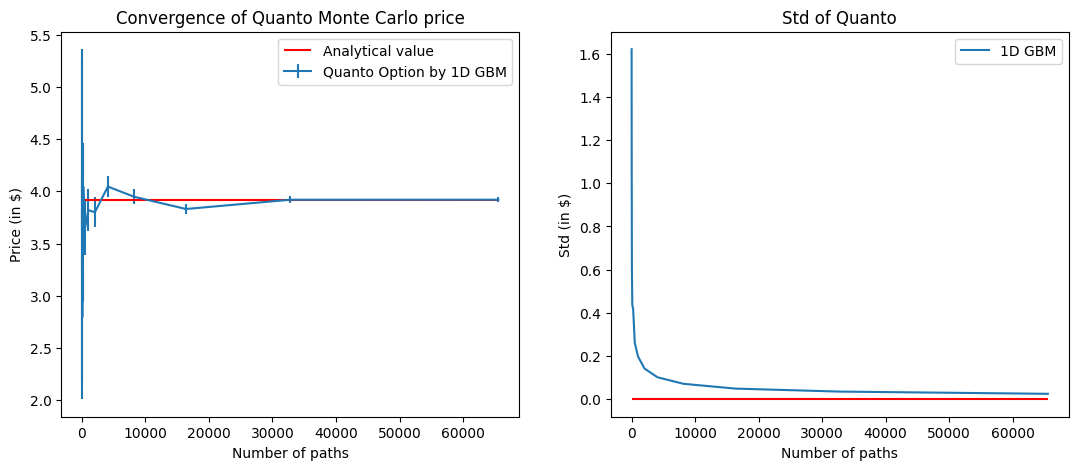

In [27]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigmaF = {sigmaF:.2f}, t = {t:.2f} years, T = {T:.2f} years, F0 = {F0:.2f}, K = {K:.2f}, M0 : {M0 :.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, oneDpricer, yerr = oneDpricerStd, label = f'Quanto Option by 1D GBM')
ax[1].plot(pathsArray, oneDpricerStd, label = "1D GBM")

ax[0].set_title('Convergence of Quanto Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =QunatoCallOption(M0, K, T, t, r, d, sigmaF, sigmaM, rho), color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Quanto')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

#Margrabe

The Margrabe option call has the following formula

$$
D\left(S_1, S_2, t\right)=S_2 N\left(d_2\right)-S_1 N\left(d_1\right)
$$

where

$$d_j=\frac{\log \left(S_2 / S_1\right)+(-1)^{j-1} \frac{1}{2} \bar{\sigma}^2\left(T-t\right)}{\bar{\sigma} \sqrt{T-t}} .
$$

and

$$
\bar{\sigma}=\sqrt{\sigma_1^2-2 \rho \sigma_1 \sigma_2+\sigma_2^2}.
$$

$S_1$ is the main underlying

$\sigma_1$ is the standard deviation of sotkc 1

$\sigma_2$ is the standard deviation of stock 2

The processes the Margrabe is based on are

$$ \frac{dS_1}{S_1} = (r + \sigma_1^2)dt + \sigma_1dW_1 $$

$$  \frac{dS_2}{S_2} = (r + \rho\sigma_1\sigma_2)dt + \sigma_2dW_2  $$

$$ \rho_{W_1,W_2} = \rho $$

$$ dB = Brdt $$

S1 is the numeraire, and B is the money market account, accruing interest at rate $r$

In [28]:
def MargrabeCallOption(S1_0, S2_0,T, t, r,sigma1, sigma2, rho):
    q1 = r + sigma1**2
    q2 = r + rho*sigma1*sigma2
    tau = T-t
    sigma_bar = np.sqrt(sigma1**2 - 2*rho*sigma1*sigma2 + sigma2**2)
    d1 = (np.log(S2_0/S1_0) + ((q1 - q2) + 0.5*sigma_bar**2)*tau)/(sigma_bar*np.sqrt(tau))
    d2 = (np.log(S2_0/S1_0) + ((q1 - q2) - 0.5*sigma_bar**2)*tau)/(sigma_bar*np.sqrt(tau))
    margrabe = S2_0*sp.special.ndtr(d1) - S1_0*sp.special.ndtr(d2)
    return margrabe

In [29]:
S1_0 = 100
S2_0 = 105
sigma1 = .07
sigma2 = .03
r = .05
rho = .25
T = 1
t=  0


In [35]:
minPower = 4
maxPower = 17
pathsArray = np.power(2,np.arange(minPower,maxPower))

In [40]:
oneDpricer = np.zeros((maxPower-minPower))
oneDpricerStd = np.zeros((maxPower-minPower))
for idx, N_paths in enumerate(pathsArray):
    #Monte Carlo Quanto pricer  -- The final price is in dollars
    W1 = np.random.normal(size=N_paths)
    W2 = np.random.normal(size=N_paths)
    Z = rho*W1 + np.sqrt(1-rho**2)*W2

    oneDS1_array = OneDGBMPathGenerator(N_paths, S1_0, T, r+sigma1**2, 0, sigma1,W1)
    oneDS2_array = OneDGBMPathGenerator(N_paths, S2_0, T, r+rho*sigma1*sigma2, 0, sigma2, Z)
    oneDD = oneDS2_array - oneDS1_array
    oneDpricer[idx] = np.mean(np.maximum(oneDD,0))
    oneDpricerStd[idx] = np.std(np.maximum(oneDD,0))/np.sqrt(N_paths)


Using parameters: r = 0.05, sigma1 = 0.07, sigma2 = 0.03, t = 0.00 years, T = 1.00 years, F0 = 1.10, rho : 0.25


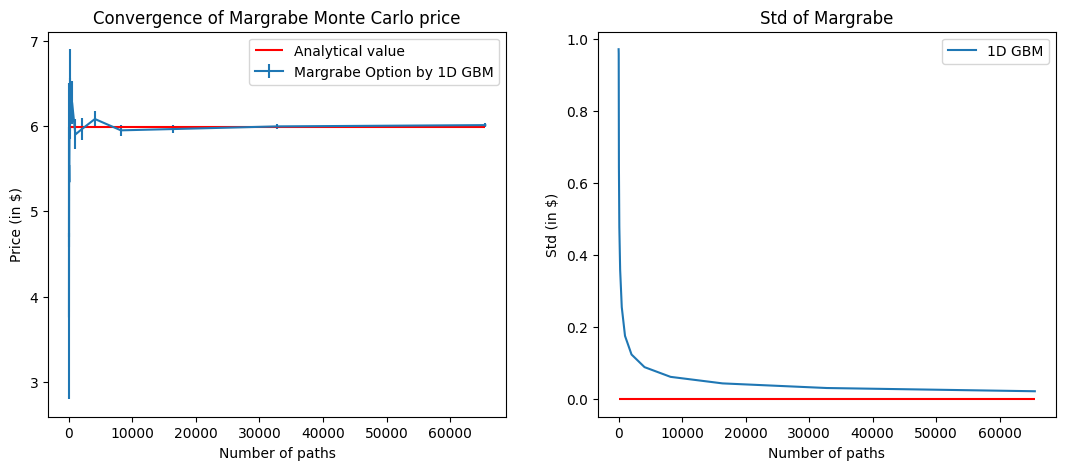

In [41]:
print(f'Using parameters: r = {r:.2f}, sigma1 = {sigma1:.2f}, sigma2 = {sigma2:.2f}, t = {t:.2f} years, T = {T:.2f} years, F0 = {F0:.2f}, rho : {rho :.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(pathsArray, oneDpricer, yerr = oneDpricerStd, label = f'Margrabe Option by 1D GBM')
ax[1].plot(pathsArray, oneDpricerStd, label = "1D GBM")

ax[0].set_title('Convergence of Margrabe Monte Carlo price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =MargrabeCallOption(S1_0, S2_0, T, t, r, sigma1, sigma2, rho), color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Margrabe')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()